In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [2]:
dropout = pd.read_csv("03 encoding.csv")
dropout.drop("Unnamed: 0", 1, inplace=True)
dropout.shape

(2750, 186)

In [3]:
dropout.head()

,disabilita,numero_fratelli_sorelle,numero_nonni_vicinanza_casa,cambio_residenza,presenza_campioni_sportivi_citta,arrampicata,arti_marziali,atletica,balli_da_sala,baseball,...,def_genitore_fastidioso,def_genitore_incoraggiante,def_genitore_indifferente,def_genitore_pesante,def_genitore_si_arrabbia_alle_gare,def_genitore_sostenitore_positivo,def_genitore_tranquillo,def_genitore_troppo_fissato,tipo_sport_significativo_individuale,tipo_sport_significativo_squadra
0,0,2,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,1,2,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,1,4,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [4]:
X = dropout.drop("dropout", 1)
y = dropout.dropout
X.shape, y.shape

((2750, 185), (2750,))

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

models = dict()
models['DecisionTree'] = dict()
params = {'criterion':['gini', 'entropy'], 'max_depth':[3, 4, 8, 12], 'min_samples_leaf':[0.05, 0.1, 0.2]}
clf = GridSearchCV(DecisionTreeClassifier(random_state=0), params, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'],
                  refit='recall').fit(X, y)
models['DecisionTree']['model'] = clf.best_estimator_
models['DecisionTree']['params'] = clf.best_params_
models['DecisionTree']['metrics'] = pd.DataFrame(clf.cv_results_).query("rank_test_recall == 1").filter(like="mean_test")
models['DecisionTree']

{'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=0.05, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=0, splitter='best'),
 'params': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 0.05},
 'metrics':    mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1
 0            0.680364             0.663654          0.758704      0.706456}

In [8]:
from sklearn import tree
tree.export_graphviz(models['DecisionTree']['model'], out_file="decision_tree_viz.dot", feature_names=X.columns, class_names=["No", "Si"])

In [10]:
importance = pd.DataFrame(models['DecisionTree']['model'].feature_importances_, columns = ['importance'])
columns_features = pd.DataFrame(X.columns, columns = ['feature'])
feat_importance = pd.concat([columns_features, importance], axis = 1)
feat_importance_sorted = feat_importance.sort_values('importance', ascending=False).query("importance > 0")
print("Numero variabili importanti: ", feat_importance_sorted.shape[0])
feat_importance_sorted

Numero variabili importanti:  5


,feature,importance
99,grado_divertimento_allenamento,0.463067
108,personalita_competitiva,0.177281
97,disponibilita_accompagnamento_genitori,0.149300
74,sport_passione,0.125684
90,grado_conciliare_scuola_sport,0.084667


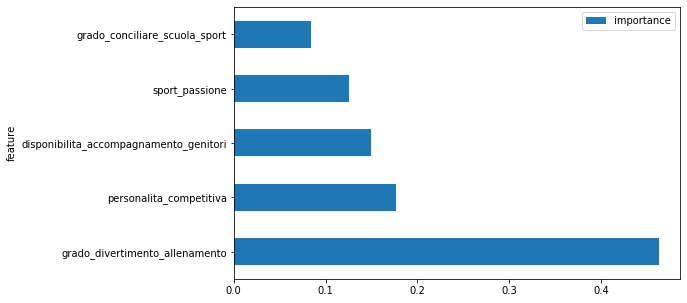

In [12]:
feat_importance_sorted.plot.barh(x="feature", y="importance", figsize=(8, 5))

In [13]:
from sklearn.ensemble import RandomForestClassifier

models['RandomForest'] = dict()
params = {'criterion':['gini'], 'max_depth':[3], 'min_samples_leaf':[0.05], 'n_estimators':[100, 200, 500], 
         'bootstrap':[True, False]}
clf = GridSearchCV(RandomForestClassifier(random_state=0), params, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'],
                  refit='recall').fit(X, y)
models['RandomForest']['model'] = clf.best_estimator_
models['RandomForest']['params'] = clf.best_params_
models['RandomForest']['metrics'] = pd.DataFrame(clf.cv_results_).query("rank_test_recall == 1").filter(like="mean_test")
models['RandomForest']

{'model': RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                        max_depth=3, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=0.05, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                        warm_start=False),
 'params': {'bootstrap': False,
  'criterion': 'gini',
  'max_depth': 3,
  'min_samples_leaf': 0.05,
  'n_estimators': 500},
 'metrics':    mean_test_accuracy  mean_test_precision  mean_test_recall  mean_test_f1
 5            0.682182             0.671225          0.743015      0.704351}

In [16]:
importance = pd.DataFrame(models['RandomForest']['model'].feature_importances_, columns = ['importance'])
columns_features = pd.DataFrame(X.columns, columns = ['feature'])
feat_importance = pd.concat([columns_features, importance], axis = 1)
feat_importance_sorted = feat_importance.sort_values('importance', ascending=False).query("importance > 0.01")
print("Numero variabili importanti: ", feat_importance_sorted.shape[0])
print(feat_importance_sorted)
print("\nSomma valori di importanza: ", sum(feat_importance_sorted.importance))

Numero variabili importanti:  21
                                  feature  importance
99         grado_divertimento_allenamento    0.153467
108               personalita_competitiva    0.111062
86                               agonismo    0.088341
74                         sport_passione    0.083153
90          grado_conciliare_scuola_sport    0.052057
114                         sesso_maschio    0.051652
11                                 calcio    0.048884
113                         sesso_femmina    0.042952
109                personalita_tranquilla    0.031205
40                           divertimento    0.029188
55                               esigenza    0.027264
72                     sport_divertimento    0.024484
111                        maschio_calcio    0.021318
101                  personalita_polemica    0.019241
93              sport_agonistico_genitori    0.017211
184      tipo_sport_significativo_squadra    0.016239
87                  frequenza_settimanale    0.01

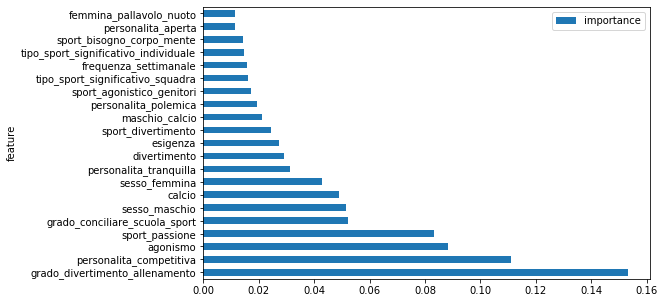

In [17]:
feat_importance_sorted.plot.barh(x="feature", y="importance", figsize=(8, 5))

In [18]:
var_imp = feat_importance_sorted.index
important_features = X.iloc[:, var_imp]
important_features['dropout'] = y
important_features.to_csv("04 important_features.csv")
important_features.shape

(2750, 22)